CREATING SONG LYRICS WITH NLP

In [2]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
import numpy as np
import pandas as pd


1. Preprocessing the lyrics

In [3]:
# We need to remove the punctuation and uppercases
def tokenize_corpus(corpus, num_words = -1):
    if num_words > -1:
        tokenizer = Tokenizer(num_words = num_words)
    else:
        tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

def create_lyrics_corpus(dataset, field):
    # Remove all other punctuation
    dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
    # Make it lowercase
    dataset[field] = dataset[field].str.lower()
    # Make it one long string to split by line
    lyrics = dataset[field].str.cat()
    corpus = lyrics.split('\n')
    # Remove any trailing whitespace
    for l in range(len(corpus)):
        corpus[l] = corpus[l].rstrip()
    # Remove any empty lines
    corpus = [l for l in corpus if l != '']

    return corpus

In [4]:
path = 'E:\\ALEJANDRO\\DATA_SCIENCE\\TENSORFLOW\\NLP_C9_10\\songdata.csv'
# ds = pd.read_csv(path, dtype=str)[:10]      # Just 10 songs the first time, but 250 if we want to get better results.
ds = pd.read_csv(path, dtype=str)[:250]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(ds, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus)
total_words = len(tokenizer.word_index) + 1

# print(tokenizer.word_index)
print(total_words)


4148


C:\Users\garci\AppData\Local\Temp/ipykernel_15852/2596313655.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')


2. Creating sequences and labels

In [5]:
# An N-gram can be considered as a sequence of N words, by that notion, a 2-gram (or bigram) is a two-word sequence of words like “please turn”, “turn your”, or 
# ”your homework”, and a 3-gram (or trigram) is a three-word sequence of words like “please turn your”, or “turn your homework”. We assign probabilities to an N-gram, 
# so that we can predict better wich words are coming next. It's more probable than we have homework, after 'turn your', than other words. Sometimes it's even like a 
# single word, like high school or San Francisco, which have a very high probability to go together.
# So we could say The N-gram is a model that predicts the next word, based on the N-1, N-2, ..., N-n words.

sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen = max_sequence_len, padding = 'pre'))
print(sequences)
print('Separator')

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# The -1 position means the last one.
print(input_sequences)
print('Separator')
print(labels)
# One-hot encode the labels. Now each labels becomes one hot encoded
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes = total_words)


[[  0   0   0 ...   0 111  66]
 [  0   0   0 ... 111  66  86]
 [  0   0   0 ...  66  86 206]
 ...
 [  0   0   0 ... 567 137  93]
 [  0   0   0 ... 137  93  20]
 [  0   0   0 ...   0 952 151]]
Separator
[[  0   0   0 ...   0   0 111]
 [  0   0   0 ...   0 111  66]
 [  0   0   0 ... 111  66  86]
 ...
 [  0   0   0 ...  15 567 137]
 [  0   0   0 ... 567 137  93]
 [  0   0   0 ...   0   0 952]]
Separator
[ 66  86 206 ...  93  20 151]


In [6]:
# Check out how some of our data is being stored
# The Tokenizer has just a single index per word
print(tokenizer.word_index['know'])
print(tokenizer.word_index['feeling'])
# Input sequences will have multiple indexes
print(input_sequences[5])
print(input_sequences[6])
# And the one hot labels will be as long as the full spread of tokenized words
print(one_hot_labels[5])
print(one_hot_labels[6])

31
158
[  0   0   0   0   0   0   0   0   0   0   0   0   0 111  66  86 206  29
   4]
[   0    0    0    0    0    0    0    0    0    0    0    0  111   66
   86  206   29    4 1196]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


3. Training a text generation model

In [7]:
# We'll use a Recurrent Neuronal Network for our model. It will be very similar to the sentiment models of the previous codes, but with the some small changes.
# It's necessary to use Categorical instead of Binary Cross Entropy as the loss function - we could use Binary before since the sentiment was only 0 or 1, but now 
# there are hundreds of categories. Also we need to use much more epochs than before, to get acceptable results.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=200, verbose=1)

Epoch 1/200
1557/1557 [==============================] - 21s 11ms/step - loss: 6.3133 - accuracy: 0.0445
Epoch 2/200
1557/1557 [==============================] - 17s 11ms/step - loss: 5.9585 - accuracy: 0.0482
Epoch 3/200
1557/1557 [==============================] - 16s 11ms/step - loss: 5.7032 - accuracy: 0.0655
Epoch 4/200
1557/1557 [==============================] - 17s 11ms/step - loss: 5.4926 - accuracy: 0.0864
Epoch 5/200
1557/1557 [==============================] - 16s 11ms/step - loss: 5.2858 - accuracy: 0.1122
Epoch 6/200
1557/1557 [==============================] - 16s 10ms/step - loss: 5.0863 - accuracy: 0.1304
Epoch 7/200
1557/1557 [==============================] - 17s 11ms/step - loss: 4.9037 - accuracy: 0.1458
Epoch 8/200
1557/1557 [==============================] - 18s 12ms/step - loss: 4.7429 - accuracy: 0.1595
Epoch 9/200
1557/1557 [==============================] - 18s 12ms/step - loss: 4.6015 - accuracy: 0.1732
Epoch 10/200
1557/1557 [==============================]

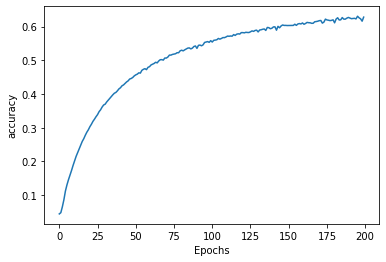

In [8]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

plot_graphs(history, 'accuracy')

In [9]:
# Finally, we generate some lyrics
seed_text = "im feeling chills"
next_words = 100

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)
# As we can see, the results are not too good. There are many repeated words, and in general, 
# the text doesn't make much sense. We'll need to improve our results.

im feeling chills me so long light me out that with you go wrong i have to go by moment ha of somebody spine embers posses bit stops married cunning owe owe paris forgot tame patronizin patronizin cut mouth fault fault fault fault fault glass pimple refined teasing plain losing seats forgot havent piper fuck fault fault fault freeze glass think covers think renee someday calm oasis havent gate a hangup tears beside bluest loveland firm shining up yeah with yeah forever trapped in cost my mind baby now stop me and see for life for you tonight honey i dont know how


In [10]:
# We generate lyrics again (2nd time, trying to get better results). This time we'll use a random function, so that we dont always get the predicted word with the 
# highest probability.
seed_text = "im feeling chills"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probs = model.predict(token_list)[0]
    print(predicted_probs)
    predicted = np.random.choice([x for x in range(len(predicted_probs))],              # Before we used argmax, to get the higher probability obtained.
                                    p=predicted_probs)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

[1.6656761e-10 3.5960533e-02 1.5181344e-03 ... 0.0000000e+00 0.0000000e+00
 2.2044516e-27]
[3.0930106e-11 1.5513013e-01 7.8138309e-03 ... 1.5636746e-34 1.0656852e-37
 4.9519472e-23]
[7.6897093e-11 1.3235353e-03 3.7439402e-02 ... 2.8827946e-22 3.4438809e-19
 4.2659964e-12]
[1.8836508e-13 8.4417668e-04 3.8056682e-05 ... 1.3158033e-24 3.0762241e-22
 2.2879774e-35]
[3.1758218e-11 3.7664941e-03 1.1959235e-06 ... 0.0000000e+00 0.0000000e+00
 3.0604291e-28]
[2.8443637e-13 2.5756444e-06 3.6176818e-05 ... 1.0508552e-24 4.6526455e-23
 1.2778533e-21]
[2.5059403e-13 7.4224189e-08 4.3866469e-04 ... 1.4186465e-33 8.3254796e-36
 4.1861590e-34]
[5.0780903e-14 7.4979803e-06 7.7214936e-04 ... 8.2035200e-32 5.9753934e-24
 1.3166172e-23]
[1.05968574e-10 4.94560366e-03 3.69987031e-03 ... 1.30136530e-23
 8.71969682e-26 1.40602799e-11]
[1.3328768e-11 1.4377538e-04 6.0659813e-06 ... 1.2754466e-31 3.1403716e-35
 4.8783963e-35]
[2.3185120e-10 9.8689422e-03 3.3142071e-05 ... 2.1634976e-34 0.0000000e+00
 1.120603